# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_parameters_kde,
                           plot_sim_results,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ikr_generic import ikr as model
test = model.sample({})
with pd.option_context('display.max_rows', None):
    print(test)

      x            y  exp
0   -80     0.002571    0
1   -70     0.021089    0
2   -60     0.080368    0
3   -50     0.206414    0
4   -40     0.365569    0
5   -30     0.472372    0
6   -20     0.482481    0
7   -10     0.385683    0
8     0     0.229300    0
9    10     0.110409    0
10   20     0.047871    0
11   30     0.019777    0
12   40     0.007985    0
0   -80     0.031461    1
1   -70     0.031574    1
2   -60     0.031859    1
3   -50     0.032465    1
4   -40     0.069372    1
5   -30     0.155469    1
6   -20     0.326301    1
7   -10     0.566842    1
8     0     0.780997    1
9    10     0.907329    1
10   20     0.965071    1
11   30     0.987700    1
12   40     0.996728    1
13   50     1.000000    1
0   -30    86.031329    2
1   -20    65.588170    2
2   -10    44.449504    2
3     0    42.071196    2
4    10    72.706891    2
5    20    60.077836    2
6    30    51.811743    2
7    40    49.729920    2
0  -120     1.559584    3
1  -110     1.891913    3
2  -100     

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_Kr=(0,10),
              Vhalf_x=(-100,0),
              k_x=(0,50),
              c_bxf=(0,10),
              c_axf=(0,1000),
              c_bxs=(0,100),
              c_axs=(0,2000),
              Vmax_x=(-100,100),
              sigma_x=(0,100),
              Vhalf_A=(-100,100),
              k_A=(-500,0),
              Vhalf_r=(-100,0),
              k_r=(-50,0),
              c_br=(0,10),
              c_ar=(0,100),
              sigma_r=(0,100),
              Vmax_r=(-100,100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [8]:
len(prior)

17

In [9]:
test = model.sample(prior.rvs())
with pd.option_context('display.max_rows', None):
    print(test)

      x            y  exp
0   -80     2.028411    0
1   -70     8.573078    0
2   -60    18.221674    0
3   -50    31.027563    0
4   -40    46.213258    0
5   -30    61.997450    0
6   -20    75.813027    0
7   -10    85.144024    0
8     0    88.428118    0
9    10    85.634533    0
10   20    78.079210    0
11   30    67.715061    0
12   40    56.418153    0
0   -80     0.332411    1
1   -70     0.333949    1
2   -60     0.335903    1
3   -50     0.338482    1
4   -40     0.410415    1
5   -30     0.492034    1
6   -20     0.580873    1
7   -10     0.671671    1
8     0     0.758448    1
9    10     0.834953    1
10   20     0.897362    1
11   30     0.944313    1
12   40     0.978011    1
13   50     1.000000    1
0   -30   177.661765    2
1   -20   124.436807    2
2   -10          inf    2
3     0          inf    2
4    10          inf    2
5    20          inf    2
6    30          inf    2
7    40          inf    2
0  -120    20.797786    3
1  -110    14.963032    3
2  -100    1

# Test parameter sensitivity

In [11]:
parameters = ['ikr.'+k for k in limits.keys()]

In [12]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

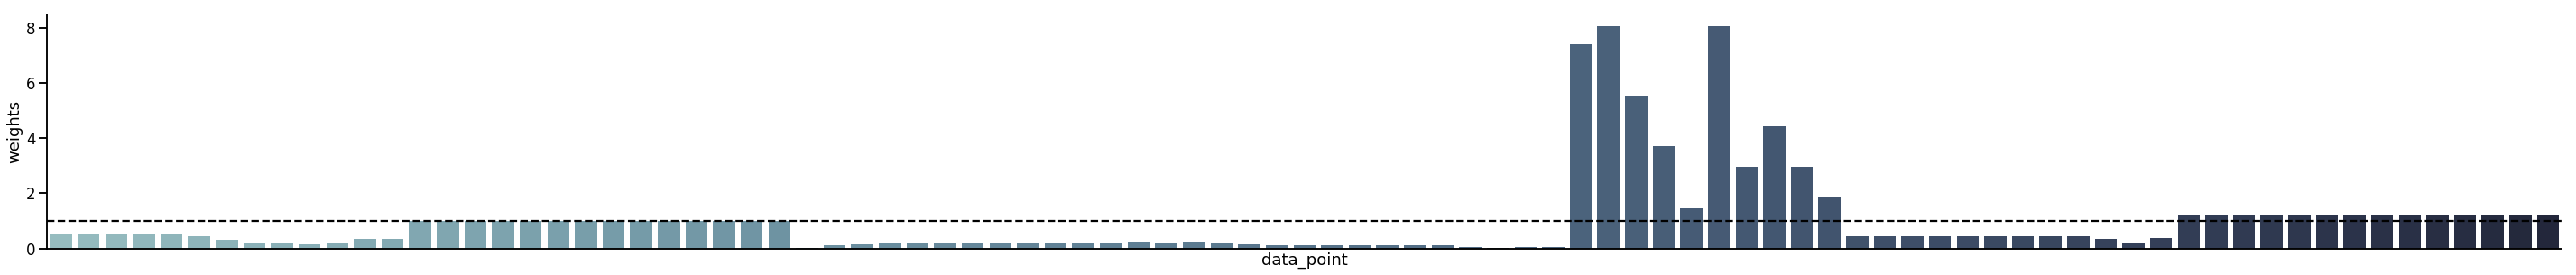

In [13]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [12]:
g.savefig('results/ikr-generic/dist_weights.pdf')

In [13]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

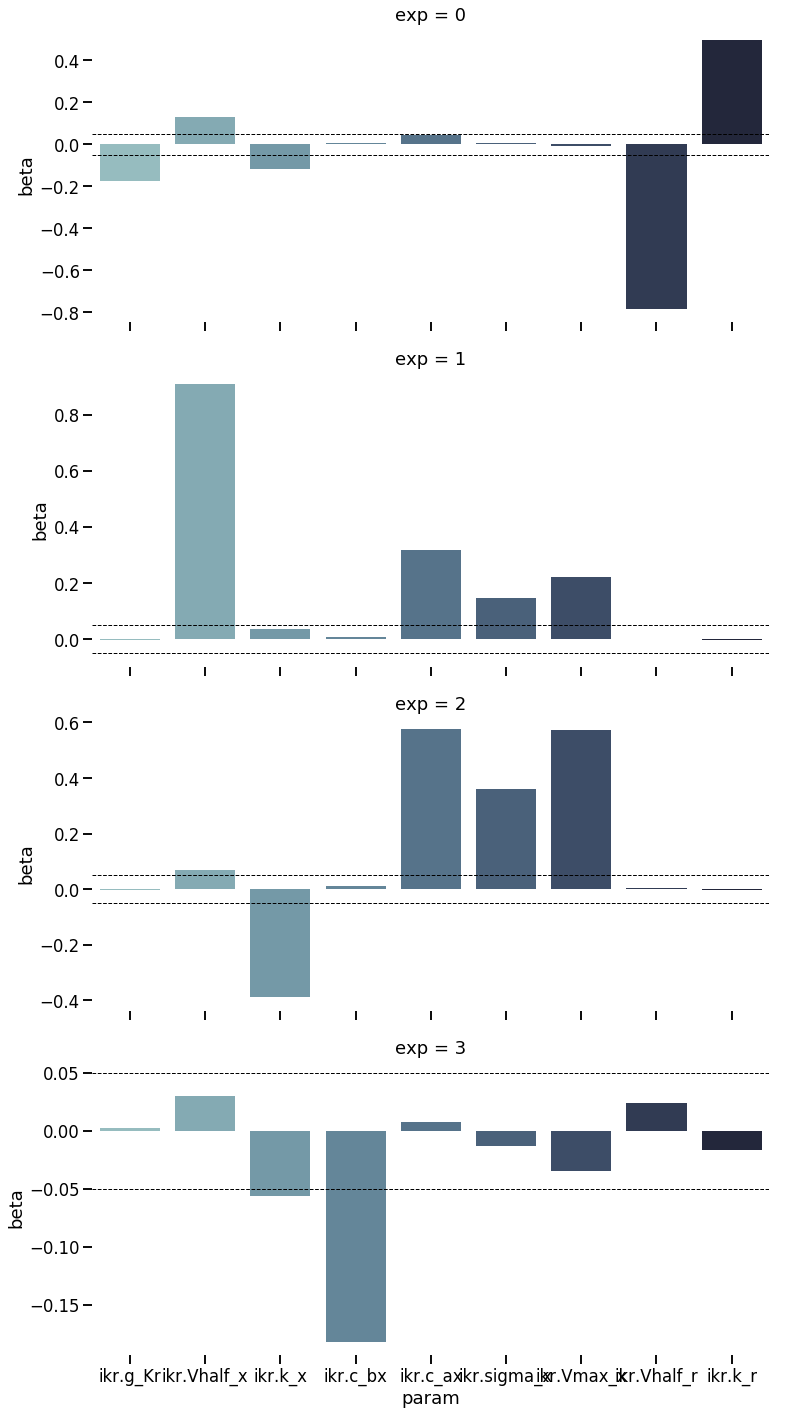

In [14]:
sns.set_context('talk')
grid1 = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

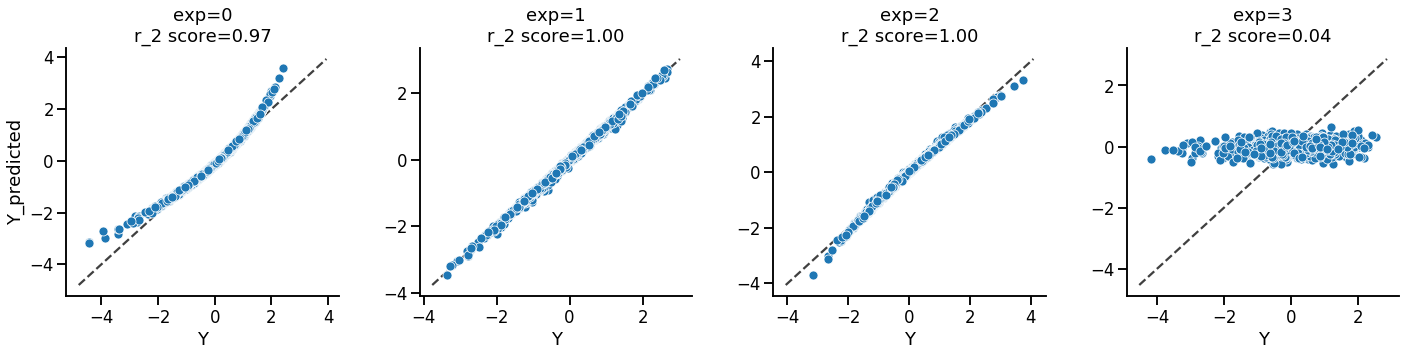

In [15]:
grid2 = plot_regression_fit(regression_fit, r2)

In [14]:
grid1.savefig('results/ikr-generic/sensitivity.pdf')
grid2.savefig('results/ikr-generic/sensitivity_fit.pdf')

In [19]:
# Finding insensitive parameters
cutoff = 0.05
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff) &
             (abs(fitted_pivot['beta'][4])<cutoff)].index.values

In [20]:
insensitive_limits = dict((k, limits[k[4:]]) for k in insensitive_params)
insensitive_prior = Distribution(**{key: RV("uniform", a, b - a)
                                 for key, (a,b) in insensitive_limits.items()})

In [21]:
# Generate random samples for insensitive parameters
def generate_sample(insensitive_prior, n):
    samples = [dict() for i in range(n)]
    for i in range(n):
        parameters = insensitive_prior.rvs()
        sample = {key: value for key, value in parameters.items()}
        samples[i].update(sample)
    return samples

In [22]:
samples = generate_sample(insensitive_prior, 1000)

In [23]:
model.add_external_par_samples(samples)

In [24]:
limits = dict((k, limits[k]) for k in limits if k[4:] not in insensitive_params)

In [9]:
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise database

In [10]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ikr-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ikr-generic.db


In [11]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [12]:
from pyabc.populationstrategy import ConstantPopulationSize

In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(5000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.5112382635044613, 1: 0.5112382635044613, 2: 0.5112382635044613, 3: 0.5112382635044613, 4: 0.5112382635044613, 5: 0.44053595194146067, 6: 0.3099974361239246, 7: 0.21461676139623864, 8: 0.17257589227517475, 9: 0.15499707412371075, 10: 0.1969395476551995, 11: 0.34162982756514215, 12: 0.35617594769081323, 13: 0.9885012423363714, 14: 0.9885012423363714, 15: 0.9885012423363714, 16: 0.9885012423363714, 17: 0.9885012423363714, 18: 0.9885012423363714, 19: 0.9885012423363714, 20: 0.9885012423363714, 21: 0.9885012423363714, 22: 0.9885012423363714, 23: 0.9885012423363714, 24: 0.9885012423363714, 25: 0.9885012423363714, 26: 0.9885012423363714, 27: 0.027978477565184273, 28: 0.11790929831041903, 29: 0.15006637966780667, 30: 0.17376107119430298, 31: 0.19535268359122754, 32: 0.19535268359122754, 33: 0.19535268359122754, 34: 0.19535268359122754, 35: 0.21231488315270317, 36: 0.21231488315270092, 37: 0.21231488315270317, 38: 0.19604741594633052, 39: 0.23161623616658478

In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=6, start_time=2019-01-14 09:57:16.629458, end_time=None)>
INFO:Epsilon:initial epsilon is 140.37902089093114


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:12 eps:27.293930335112986


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.001)

# Results analysis

In [16]:
#db_path = 'sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/ikr-generic/hl-1_ikr-generic.db'
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_ikr-generic.db'

history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-12-20 17:03:36.271035, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-12-27 08:59:49.702494, end_time=None)>,
 <ABCSMC(id=3, start_time=2019-01-03 10:19:54.455157, end_time=None)>,
 <ABCSMC(id=4, start_time=2019-01-03 13:00:22.900417, end_time=None)>,
 <ABCSMC(id=5, start_time=2019-01-09 09:24:51.195188, end_time=None)>,
 <ABCSMC(id=6, start_time=2019-01-14 09:57:16.629458, end_time=None)>]

In [17]:
history.id = 6

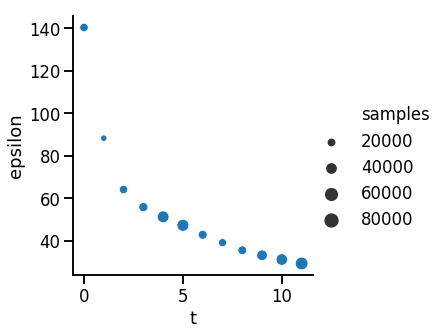

In [18]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#grid.savefig('results/ikr-generic/eps_evolution.pdf')

In [33]:
df, w = history.get_distribution(m=0)

In [34]:
df.describe()

name,Vhalf_A,Vhalf_r,Vhalf_x,Vmax_r,Vmax_xf,Vmax_xs,c_ar,c_axf,c_axs,c_br,c_bxf,c_bxs,g_Kr,k_A,k_r,k_x,sigma_r,sigma_xf,sigma_xs
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-7.144726,-65.878101,-15.358063,38.403975,-11.477626,7.643137,40.449322,572.168874,459.651011,3.113223,6.298186,36.943797,3.753223,-234.707639,-19.111734,8.811790,36.851781,27.820000,34.962577
std,48.760748,20.755529,9.229797,37.785868,30.182911,43.019578,24.954037,202.723182,220.666783,1.957167,2.281973,21.892117,2.235997,119.236576,10.239013,4.529211,21.687040,13.640293,19.645690
min,-99.915804,-99.997217,-44.240795,-99.827250,-72.471410,-86.993748,0.009551,4.202060,0.230953,0.000256,0.008638,0.025828,0.004039,-499.966276,-49.935756,0.043367,0.012969,0.826864,0.035649
25%,-45.504815,-81.845646,-21.280623,15.933215,-30.570603,-31.099895,20.450809,450.734642,311.580232,1.581711,4.740676,18.618313,1.956724,-325.099986,-25.731405,5.113880,19.635302,19.548464,21.393904
50%,-10.546198,-68.065314,-14.276153,41.629632,-25.021470,-4.536847,37.481173,583.428723,464.574473,2.910750,6.616999,35.379505,3.597575,-224.860336,-18.268610,8.628690,35.154964,25.004594,28.828159
75%,29.390878,-53.104682,-8.226335,67.282050,-1.408394,44.996192,57.536468,715.907010,606.643507,4.354668,8.100539,52.567229,5.246290,-141.297668,-11.385465,12.251088,51.199648,31.496756,45.442610
max,99.991856,-0.080639,-0.002146,99.959893,99.767827,99.983559,99.940900,999.664807,998.697524,9.940093,9.997001,99.979164,9.985341,-0.081244,-0.163209,22.582093,99.972918,98.763497,99.987702


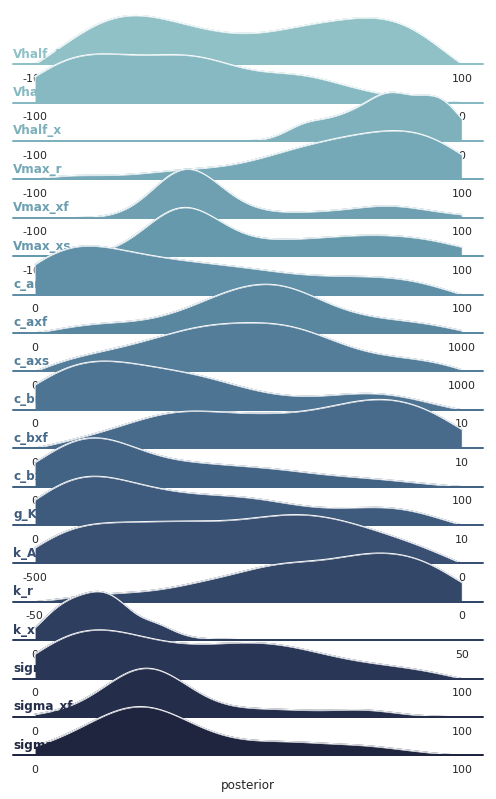

In [35]:
g = plot_parameters_kde(df, w, limits, aspect=12, height=0.6)

In [52]:
g.savefig('results/ikr-generic/parameters_kde.pdf')

# Samples for quantitative analysis

In [36]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [37]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=20)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

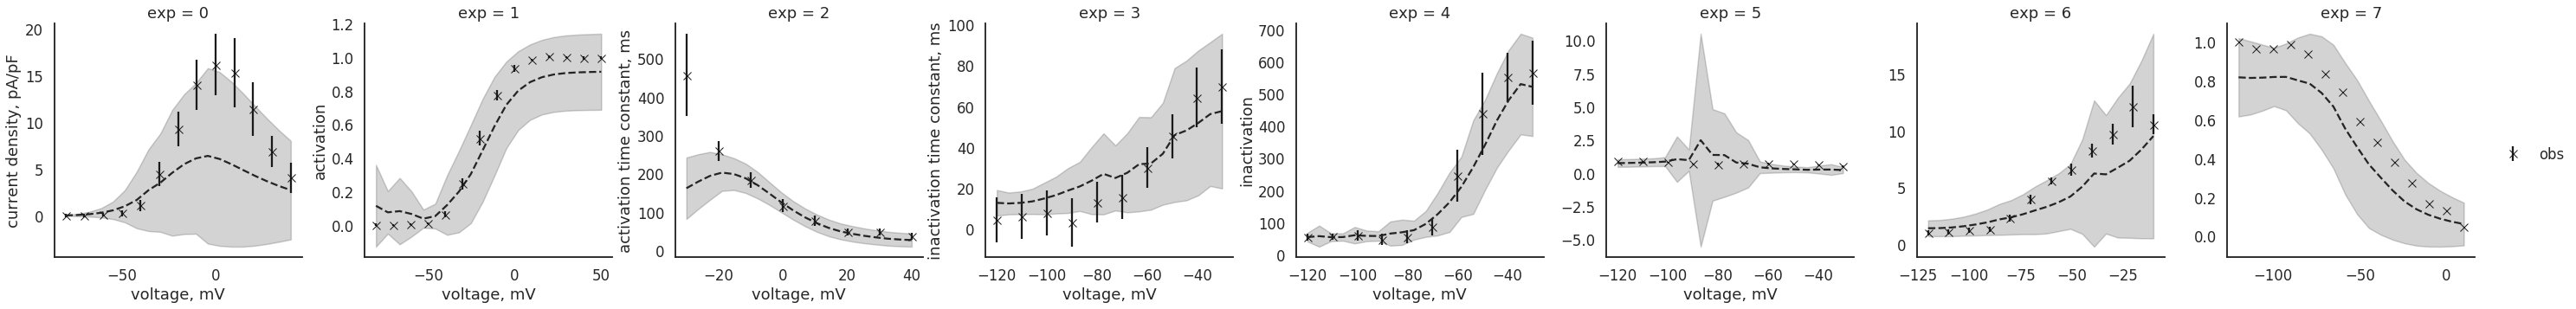

In [38]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "voltage, mV",
           "voltage, mV", "voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "activation time constant, ms",
           "inactivation time constant, ms", "inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [39]:
g.savefig('results/ikr-generic/ikr_sim_results.pdf')

In [84]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

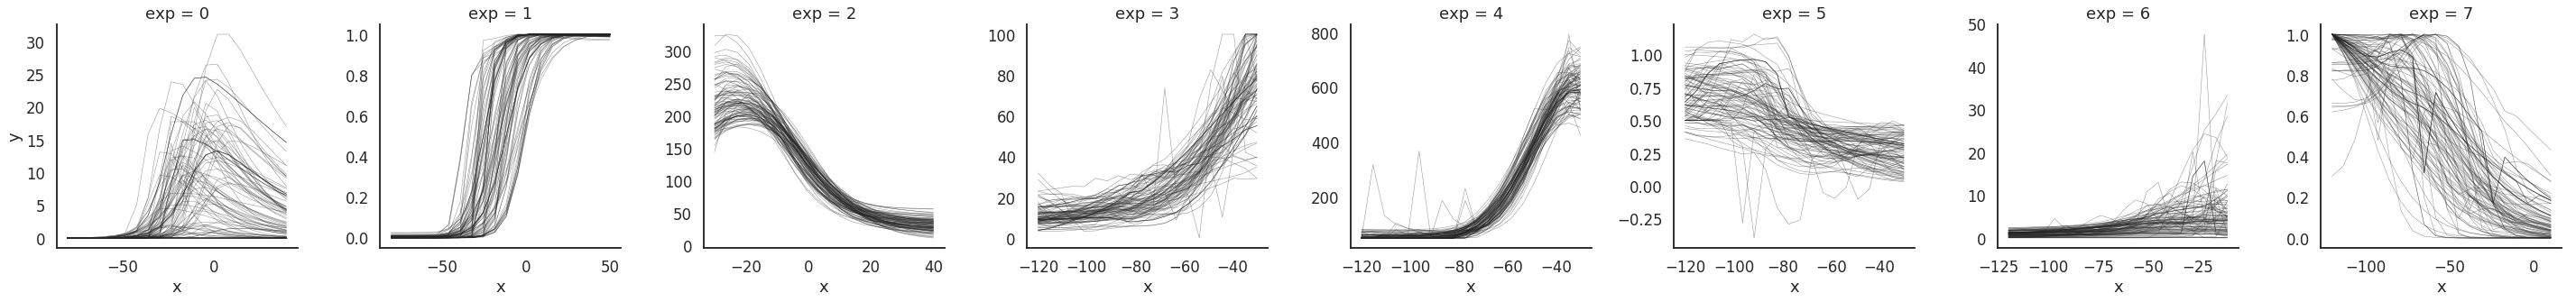

In [85]:
grid2 = plot_sim_results_all(samples)

In [42]:
grid2.savefig('results/ikr-generic/ikr_sim_results-all.pdf')

In [40]:
# Activation fit to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [41]:
import scipy.stats as st
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -25.40324884673613
95% CI: (-26.82172946410983, -23.973285026324227)


In [42]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 3.8020207463420266
95% CI: (3.551669741419606, 4.196882888137133)


In [43]:
# Inactivation fit to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-40, 30)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy-1.2.0.dev0+ff70097-py3.6-linux-x86_64.egg/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [44]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 49.18417632012099
95% CI: (15.11793999134301, 56.270848134249356)


In [45]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 0.5109144771643899
95% CI: (0.023141315468780288, 0.8326514852747855)
